In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import kagglehub
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


/home/mohitch/Documents/FML/Project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Downloading dataset...")
dataset_path = kagglehub.dataset_download("elikplim/eergy-efficiency-dataset")
df = pd.read_csv(dataset_path + "/ENB2012_data.csv")

print(f"Dataset shape: {df.shape}")
print(df.head())

# Prepare data
X = df.drop(['Y1', 'Y2'], axis=1).values
y = df['Y1'].values  # Heating load as target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1)

print(f"Training set: {X_train_tensor.shape}, Test set: {X_test_tensor.shape}")

Dataset shape: (768, 10)
     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
Training set: torch.Size([614, 8]), Test set: torch.Size([154, 8])


In [3]:
class BaseNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=50):
        super(BaseNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# 1. Standard Neural Network
class StandardNN(BaseNN):
    def __init__(self, input_dim, hidden_dim=50):
        super(StandardNN, self).__init__(input_dim, hidden_dim)

In [4]:
class MCDropoutNN(BaseNN):
    def __init__(self, input_dim, hidden_dim=50, dropout_rate=0.1):
        super(MCDropoutNN, self).__init__(input_dim, hidden_dim)
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(dropout_rate),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

In [5]:
class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_var=1.0):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.w_mu = nn.Parameter(torch.Tensor(out_features, in_features).normal_(0, 0.1))
        self.w_rho = nn.Parameter(torch.Tensor(out_features, in_features).fill_(-3.0))
        self.b_mu = nn.Parameter(torch.Tensor(out_features).normal_(0, 0.1))
        self.b_rho = nn.Parameter(torch.Tensor(out_features).fill_(-3.0))
        self.prior_var = prior_var
        
    def forward(self, x, sample=True):
        w_sigma = torch.log1p(torch.exp(self.w_rho))
        b_sigma = torch.log1p(torch.exp(self.b_rho))
        if self.training or sample:
            eps_w = torch.randn_like(self.w_mu)
            eps_b = torch.randn_like(self.b_mu)
            w = self.w_mu + w_sigma * eps_w
            b = self.b_mu + b_sigma * eps_b
        else:
            w = self.w_mu
            b = self.b_mu
        return F.linear(x, w, b)
    
    def kl_loss(self):
        w_sigma = torch.log1p(torch.exp(self.w_rho))
        b_sigma = torch.log1p(torch.exp(self.b_rho))
        kl_w = 0.5 * ( (w_sigma**2 + self.w_mu**2)/self.prior_var - 1 + math.log(self.prior_var) - 2*torch.log(w_sigma.clamp(min=1e-8)) )
        kl_b = 0.5 * ( (b_sigma**2 + self.b_mu**2)/self.prior_var - 1 + math.log(self.prior_var) - 2*torch.log(b_sigma.clamp(min=1e-8)) )
        return kl_w.sum() + kl_b.sum()

In [6]:
class BayesianReg(nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()
        self.l1 = BayesLinear(in_dim, 128)
        self.l2 = BayesLinear(128, 64)
        self.out = BayesLinear(64, out_dim)
        
    def forward(self, x, sample=True):
        x = F.relu(self.l1(x, sample=sample))
        x = F.relu(self.l2(x, sample=sample))
        return self.out(x, sample=sample)
    
    def kl_loss(self):
        return self.l1.kl_loss() + self.l2.kl_loss() + self.out.kl_loss()

In [7]:
class PBPNN:
    def __init__(self, input_dim, hidden_dim=50):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.models = []
        
    def train_ensemble(self, X_train, y_train, n_models=10):
        """Train an ensemble of neural networks"""
        self.models = []
        for i in range(n_models):
            print(f"Training PBP model {i+1}/{n_models}")
            model = StandardNN(self.input_dim, self.hidden_dim)
            optimizer = optim.Adam(model.parameters(), lr=0.001)
            criterion = nn.MSELoss()
            
            # Train each model
            for epoch in range(100):
                optimizer.zero_grad()
                outputs = model(X_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
            
            self.models.append(model)
    
    def predict(self, X, n_samples=100):
        """Predict using ensemble with minimum uncertainty"""
        if not self.models:
            raise ValueError("Models not trained. Call train_ensemble first.")
        
        all_predictions = []
        for model in self.models:
            model.eval()
            with torch.no_grad():
                preds = model(X).numpy()
                all_predictions.append(preds)
        
        all_predictions = np.array(all_predictions)
        mean_pred = np.mean(all_predictions, axis=0).flatten()
        std_pred = np.std(all_predictions, axis=0).flatten()
        
        # Ensure minimum uncertainty
        min_uncertainty = 1e-6
        std_pred = np.maximum(std_pred, min_uncertainty)
        
        return mean_pred, std_pred

In [8]:
def train_standard_model(model, X_train, y_train, epochs=300, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    return losses

In [9]:
def train_mc_dropout_model(model, X_train, y_train, epochs=300, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    return losses

In [10]:
def train_bayesian_model(model, X_train, y_train, epochs=500, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass with sampling
        outputs = model(X_train, sample=True)
        mse_loss = criterion(outputs, y_train)
        kl_loss = model.kl_loss()
        
        # Use a small KL weight
        kl_weight = 1e-4
        total_loss = mse_loss + kl_weight * kl_loss
        
        total_loss.backward()
        optimizer.step()
        losses.append(total_loss.item())
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Total Loss: {total_loss.item():.4f}, "
                  f"MSE: {mse_loss.item():.4f}, KL: {kl_loss.item():.4f}")
    
    return losses


In [11]:
print("Training Standard NN...")
standard_model = StandardNN(X_train_tensor.shape[1])
train_standard_model(standard_model, X_train_tensor, y_train_tensor)

print("\nTraining MC Dropout NN...")
mc_dropout_model = MCDropoutNN(X_train_tensor.shape[1], dropout_rate=0.1)
train_mc_dropout_model(mc_dropout_model, X_train_tensor, y_train_tensor)

print("\nTraining Variational Inference (BayesianReg) model...")
vi_model = BayesianReg(X_train_tensor.shape[1])
train_bayesian_model(vi_model, X_train_tensor, y_train_tensor, epochs=300)

print("\nTraining PBP Ensemble...")
pbp_model = PBPNN(X_train_tensor.shape[1])
pbp_model.train_ensemble(X_train_tensor, y_train_tensor, n_models=10)

Training Standard NN...
Epoch 0, Loss: 592.5334
Epoch 100, Loss: 85.1394
Epoch 200, Loss: 26.6445

Training MC Dropout NN...
Epoch 0, Loss: 598.7504
Epoch 100, Loss: 121.7837
Epoch 200, Loss: 30.2014

Training Variational Inference (BayesianReg) model...
Epoch 0, Total Loss: 590.4423, MSE: 588.0450, KL: 23972.1367
Epoch 100, Total Loss: 35.7873, MSE: 33.3938, KL: 23934.9258
Epoch 200, Total Loss: 22.8577, MSE: 20.4680, KL: 23896.9297

Training PBP Ensemble...
Training PBP model 1/10
Training PBP model 2/10
Training PBP model 3/10
Training PBP model 4/10
Training PBP model 5/10
Training PBP model 6/10
Training PBP model 7/10
Training PBP model 8/10
Training PBP model 9/10
Training PBP model 10/10


In [12]:
def calculate_nll(y_true, y_pred, y_std):
    """Calculate Negative Log Likelihood with numerical stability"""
    epsilon = 1e-6
    y_std_safe = np.maximum(y_std, epsilon)
    
    nll = 0.5 * np.log(2 * np.pi * y_std_safe**2) + 0.5 * ((y_true - y_pred) / y_std_safe)**2
    return np.mean(nll)

def calculate_metrics(y_true, y_pred, y_unc):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    nll = calculate_nll(y_true, y_pred, y_unc)
    return rmse, nll

In [13]:
def evaluate_model(model, X_test, y_test, model_type, n_samples=100):
    """Evaluate model and return predictions with uncertainties"""
    with torch.no_grad():
        if model_type == "standard":
            model.eval()
            predictions = model(X_test).numpy().flatten()
            residuals = predictions - y_test.numpy().flatten()
            uncertainty = np.std(residuals) * np.ones_like(predictions)
            
        elif model_type == "mc_dropout":
            model.train()  # Keep dropout active
            all_predictions = []
            for _ in range(n_samples):
                pred = model(X_test).numpy()
                all_predictions.append(pred)
            
            all_predictions = np.array(all_predictions)
            predictions = np.mean(all_predictions, axis=0).flatten()
            uncertainty = np.std(all_predictions, axis=0).flatten()
            
        elif model_type == "vi":
            # For BayesianReg, use multiple samples with sampling
            all_predictions = []
            for _ in range(n_samples):
                pred = model(X_test, sample=True).numpy()
                all_predictions.append(pred)
            
            all_predictions = np.array(all_predictions)
            predictions = np.mean(all_predictions, axis=0).flatten()
            uncertainty = np.std(all_predictions, axis=0).flatten()
            
        elif model_type == "pbp":
            predictions, uncertainty = model.predict(X_test)
            
        else:
            raise ValueError("Unknown model type")
    
    # Ensure reasonable uncertainty bounds
    min_uncertainty = 0.1
    uncertainty = np.maximum(uncertainty, min_uncertainty)
    
    return predictions, uncertainty


In [14]:
print("Evaluating models...")
y_test_np = y_test_tensor.numpy().flatten()

# Evaluate all models
std_pred, std_unc = evaluate_model(standard_model, X_test_tensor, y_test_tensor, "standard")
mc_pred, mc_unc = evaluate_model(mc_dropout_model, X_test_tensor, y_test_tensor, "mc_dropout")
vi_pred, vi_unc = evaluate_model(vi_model, X_test_tensor, y_test_tensor, "vi")
pbp_pred, pbp_unc = evaluate_model(pbp_model, X_test_tensor, y_test_tensor, "pbp")

# Calculate metrics
std_rmse, std_nll = calculate_metrics(y_test_np, std_pred, std_unc)
mc_rmse, mc_nll = calculate_metrics(y_test_np, mc_pred, mc_unc)
vi_rmse, vi_nll = calculate_metrics(y_test_np, vi_pred, vi_unc)
pbp_rmse, pbp_nll = calculate_metrics(y_test_np, pbp_pred, pbp_unc)

print("\n=== Model Performance ===")
print(f"Standard NN - RMSE: {std_rmse:.4f}, NLL: {std_nll:.4f}")
print(f"MC Dropout - RMSE: {mc_rmse:.4f}, NLL: {mc_nll:.4f}") 
print(f"VI (BayesianReg) - RMSE: {vi_rmse:.4f}, NLL: {vi_nll:.4f}")
print(f"PBP - RMSE: {pbp_rmse:.4f}, NLL: {pbp_nll:.4f}")


Evaluating models...

=== Model Performance ===
Standard NN - RMSE: 4.7562, NLL: 2.9784
MC Dropout - RMSE: 4.7240, NLL: 3.8325
VI (BayesianReg) - RMSE: 3.9916, NLL: 5.1372
PBP - RMSE: 8.6419, NLL: 9.3661


In [15]:
print("\n=== Uncertainty Statistics ===")
print(f"Standard NN uncertainty - Min: {std_unc.min():.6f}, Max: {std_unc.max():.6f}, Mean: {std_unc.mean():.6f}")
print(f"MC Dropout uncertainty - Min: {mc_unc.min():.6f}, Max: {mc_unc.max():.6f}, Mean: {mc_unc.mean():.6f}")
print(f"VI uncertainty - Min: {vi_unc.min():.6f}, Max: {vi_unc.max():.6f}, Mean: {vi_unc.mean():.6f}")
print(f"PBP uncertainty - Min: {pbp_unc.min():.6f}, Max: {pbp_unc.max():.6f}, Mean: {pbp_unc.mean():.6f}")


=== Uncertainty Statistics ===
Standard NN uncertainty - Min: 4.747084, Max: 4.747084, Mean: 4.747084
MC Dropout uncertainty - Min: 0.899331, Max: 4.255580, Mean: 2.157241
VI uncertainty - Min: 0.609976, Max: 2.286031, Mean: 1.348846
PBP uncertainty - Min: 0.799191, Max: 4.655035, Mean: 2.149657


In [16]:
def multiple_runs(n_runs=5):
    std_rmses, std_nlls = [], []
    mc_rmses, mc_nlls = [], []
    vi_rmses, vi_nlls = [], []
    pbp_rmses, pbp_nlls = [], []
    
    for run in range(n_runs):
        print(f"Run {run+1}/{n_runs}")
        
        # Re-initialize and train models
        # Standard NN
        std_model = StandardNN(X_train_tensor.shape[1])
        train_standard_model(std_model, X_train_tensor, y_train_tensor, epochs=100)
        std_pred, std_unc = evaluate_model(std_model, X_test_tensor, y_test_tensor, "standard")
        std_rmse, std_nll = calculate_metrics(y_test_np, std_pred, std_unc)
        std_rmses.append(std_rmse)
        std_nlls.append(std_nll)
        
        # MC Dropout
        mc_model = MCDropoutNN(X_train_tensor.shape[1])
        train_mc_dropout_model(mc_model, X_train_tensor, y_train_tensor, epochs=100)
        mc_pred, mc_unc = evaluate_model(mc_model, X_test_tensor, y_test_tensor, "mc_dropout")
        mc_rmse, mc_nll = calculate_metrics(y_test_np, mc_pred, mc_unc)
        mc_rmses.append(mc_rmse)
        mc_nlls.append(mc_nll)
        
        # VI
        vi_model_run = BayesianReg(X_train_tensor.shape[1])
        train_bayesian_model(vi_model_run, X_train_tensor, y_train_tensor, epochs=100)
        vi_pred, vi_unc = evaluate_model(vi_model_run, X_test_tensor, y_test_tensor, "vi")
        vi_rmse, vi_nll = calculate_metrics(y_test_np, vi_pred, vi_unc)
        vi_rmses.append(vi_rmse)
        vi_nlls.append(vi_nll)
        
        # PBP
        pbp_model_run = PBPNN(X_train_tensor.shape[1])
        pbp_model_run.train_ensemble(X_train_tensor, y_train_tensor, n_models=5)
        pbp_pred, pbp_unc = evaluate_model(pbp_model_run, X_test_tensor, y_test_tensor, "pbp")
        pbp_rmse, pbp_nll = calculate_metrics(y_test_np, pbp_pred, pbp_unc)
        pbp_rmses.append(pbp_rmse)
        pbp_nlls.append(pbp_nll)
    
    return (std_rmses, std_nlls, mc_rmses, mc_nlls, vi_rmses, vi_nlls, pbp_rmses, pbp_nlls)

In [17]:
print("Running multiple evaluations for standard deviation...")
results = multiple_runs(n_runs=3)

Running multiple evaluations for standard deviation...
Run 1/3
Epoch 0, Loss: 590.7468
Epoch 0, Loss: 602.3299
Epoch 0, Total Loss: 582.9492, MSE: 580.5519, KL: 23972.2969
Training PBP model 1/5
Training PBP model 2/5
Training PBP model 3/5
Training PBP model 4/5
Training PBP model 5/5
Run 2/3
Epoch 0, Loss: 590.7789
Epoch 0, Loss: 584.7750
Epoch 0, Total Loss: 588.1717, MSE: 585.7745, KL: 23972.1738
Training PBP model 1/5
Training PBP model 2/5
Training PBP model 3/5
Training PBP model 4/5
Training PBP model 5/5
Run 3/3
Epoch 0, Loss: 587.9590
Epoch 0, Loss: 590.1594
Epoch 0, Total Loss: 595.1616, MSE: 592.7645, KL: 23971.6797
Training PBP model 1/5
Training PBP model 2/5
Training PBP model 3/5
Training PBP model 4/5
Training PBP model 5/5


In [18]:
def format_result(values, decimals=2):
    return f"{np.mean(values):.{decimals}f} ±{np.std(values):.{decimals}f}"

std_rmse_final = format_result(results[0])
std_nll_final = format_result(results[1])
mc_rmse_final = format_result(results[2])
mc_nll_final = format_result(results[3])
vi_rmse_final = format_result(results[4])
vi_nll_final = format_result(results[5])
pbp_rmse_final = format_result(results[6])
pbp_nll_final = format_result(results[7])

In [19]:
print("\n" + "="*50)
print("FINAL RESULTS TABLE")
print("="*50)
print("\nAvg. Test RMSE and Std. Errors")
print(f"{'VI':<10} {vi_rmse_final}")
print(f"{'PBP':<10} {pbp_rmse_final}")
print(f"{'Dropout':<10} {mc_rmse_final}")
print(f"{'Standard':<10} {std_rmse_final}")

print("\nAvg. Test NLL and Std. Errors")
print(f"{'VI':<10} {vi_nll_final}")
print(f"{'PBP':<10} {pbp_nll_final}")
print(f"{'Dropout':<10} {mc_nll_final}")
print(f"{'Standard':<10} {std_nll_final}")
print("="*50)


FINAL RESULTS TABLE

Avg. Test RMSE and Std. Errors
VI         6.30 ±0.09
PBP        9.78 ±0.67
Dropout    8.89 ±1.32
Standard   9.44 ±0.93

Avg. Test NLL and Std. Errors
VI         10.48 ±0.57
PBP        18.94 ±5.15
Dropout    19.04 ±7.93
Standard   3.76 ±0.17


In [20]:
plt.style.use('default')
sns.set_palette("husl")


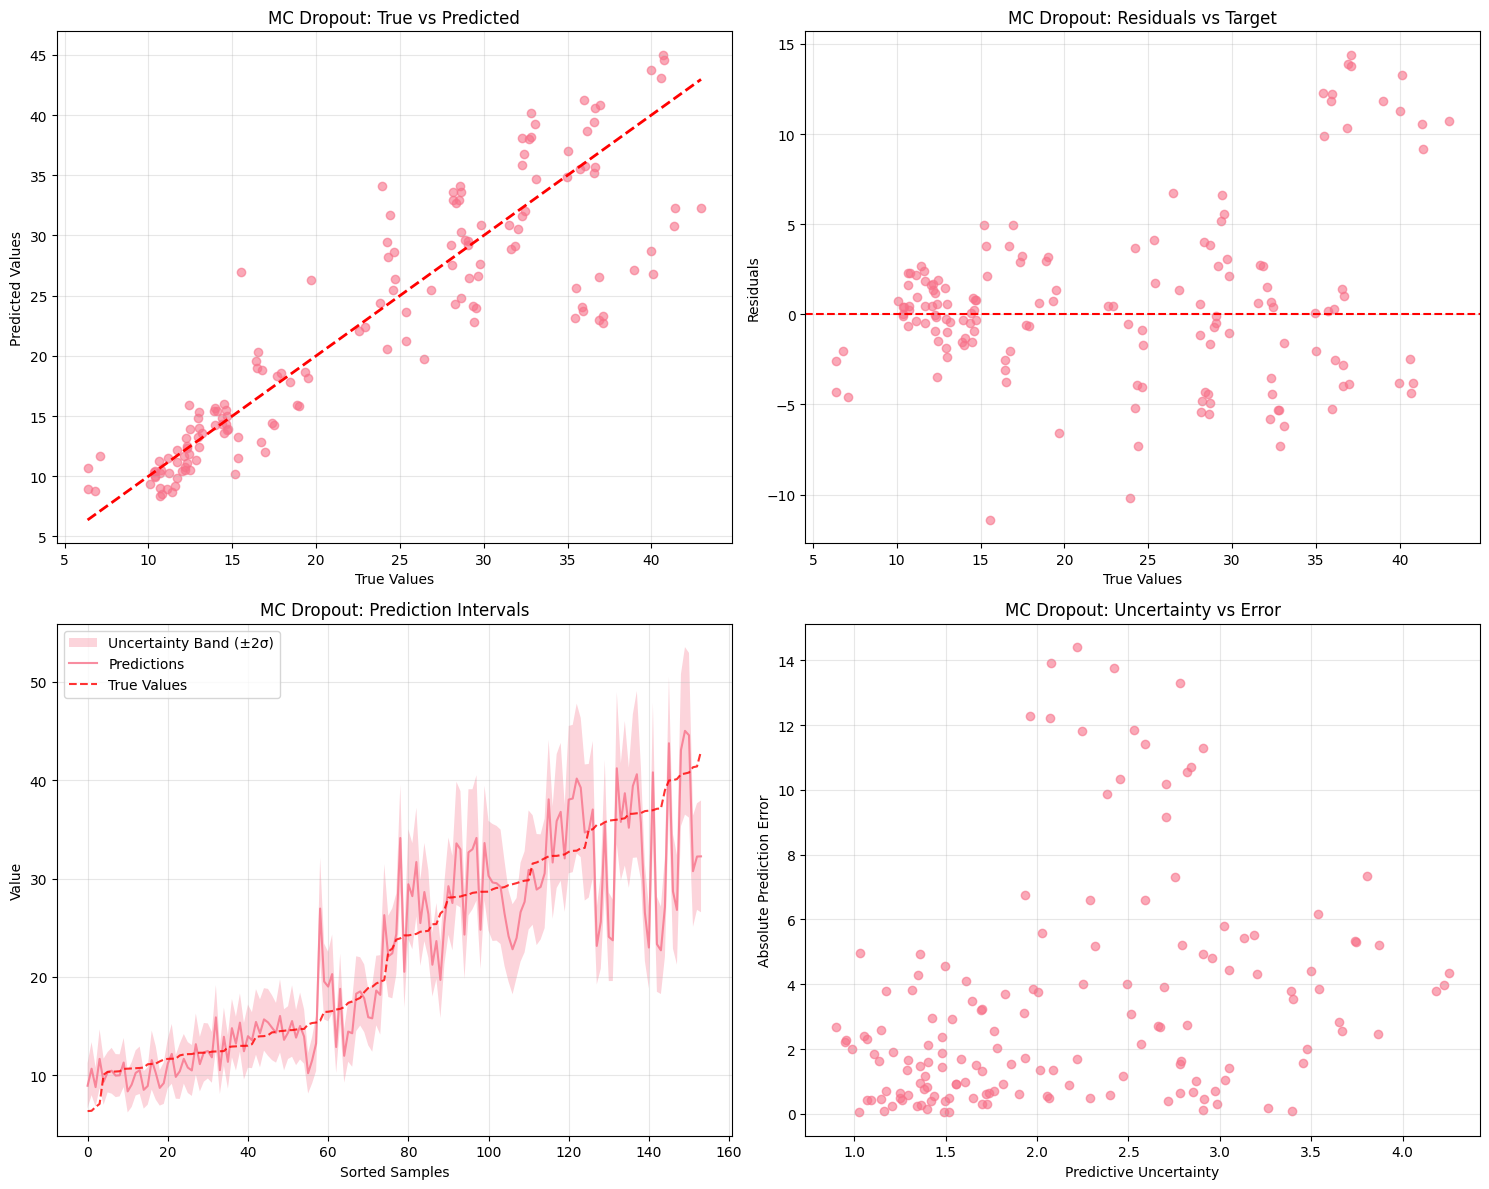

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# True vs Predicted Scatter Plot
axes[0,0].scatter(y_test_np, mc_pred, alpha=0.6)
axes[0,0].plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', lw=2)
axes[0,0].set_xlabel('True Values')
axes[0,0].set_ylabel('Predicted Values')
axes[0,0].set_title('MC Dropout: True vs Predicted')
axes[0,0].grid(True, alpha=0.3)

# Residuals Plot
residuals = y_test_np - mc_pred
axes[0,1].scatter(y_test_np, residuals, alpha=0.6)
axes[0,1].axhline(y=0, color='r', linestyle='--')
axes[0,1].set_xlabel('True Values')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('MC Dropout: Residuals vs Target')
axes[0,1].grid(True, alpha=0.3)

# Prediction Interval Plot
sorted_idx = np.argsort(y_test_np)
y_sorted = y_test_np[sorted_idx]
pred_sorted = mc_pred[sorted_idx]
unc_sorted = mc_unc[sorted_idx]

axes[1,0].fill_between(range(len(y_sorted)), 
                      pred_sorted - 2*unc_sorted, 
                      pred_sorted + 2*unc_sorted, 
                      alpha=0.3, label='Uncertainty Band (±2σ)')
axes[1,0].plot(pred_sorted, label='Predictions', alpha=0.8)
axes[1,0].plot(y_sorted, 'r--', label='True Values', alpha=0.8)
axes[1,0].set_xlabel('Sorted Samples')
axes[1,0].set_ylabel('Value')
axes[1,0].set_title('MC Dropout: Prediction Intervals')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Uncertainty vs Prediction Error Scatter Plot
pred_error = np.abs(residuals)
axes[1,1].scatter(mc_unc, pred_error, alpha=0.6)
axes[1,1].set_xlabel('Predictive Uncertainty')
axes[1,1].set_ylabel('Absolute Prediction Error')
axes[1,1].set_title('MC Dropout: Uncertainty vs Error')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

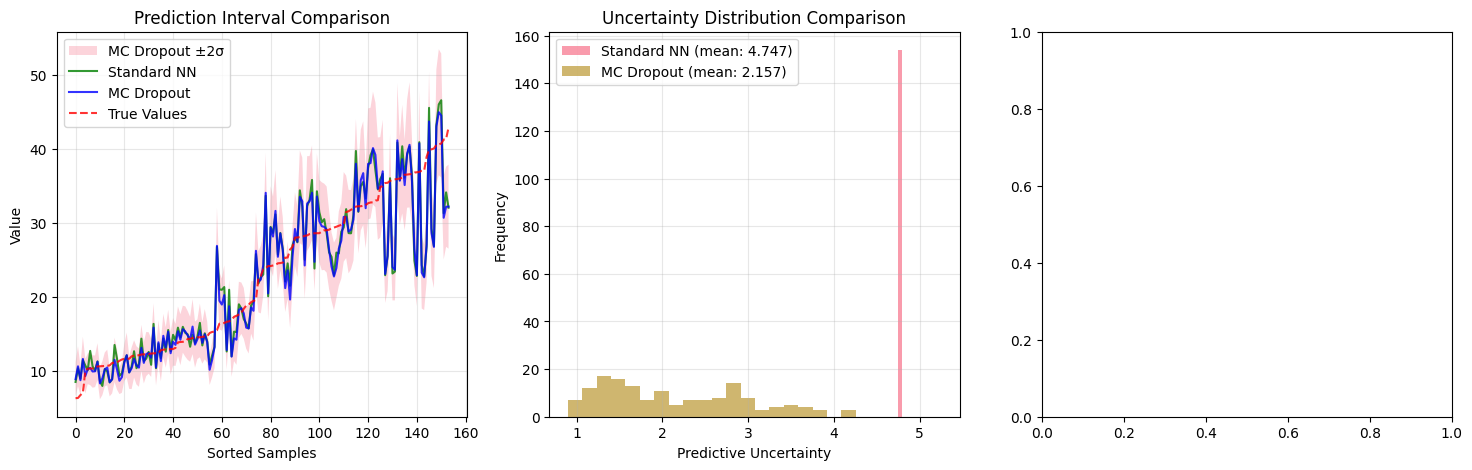

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Prediction Interval Overlay
sorted_idx = np.argsort(y_test_np)
y_sorted = y_test_np[sorted_idx]

axes[0].fill_between(range(len(y_sorted)), 
                    mc_pred[sorted_idx] - 2*mc_unc[sorted_idx], 
                    mc_pred[sorted_idx] + 2*mc_unc[sorted_idx], 
                    alpha=0.3, label='MC Dropout ±2σ')
axes[0].plot(std_pred[sorted_idx], 'g-', label='Standard NN', alpha=0.8)
axes[0].plot(mc_pred[sorted_idx], 'b-', label='MC Dropout', alpha=0.8)
axes[0].plot(y_sorted, 'r--', label='True Values', alpha=0.8)
axes[0].set_xlabel('Sorted Samples')
axes[0].set_ylabel('Value')
axes[0].set_title('Prediction Interval Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Uncertainty Distribution Plot
axes[1].hist(std_unc, bins=20, alpha=0.7, label=f'Standard NN (mean: {np.mean(std_unc):.3f})')
axes[1].hist(mc_unc, bins=20, alpha=0.7, label=f'MC Dropout (mean: {np.mean(mc_unc):.3f})')
axes[1].set_xlabel('Predictive Uncertainty')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Uncertainty Distribution Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

In [24]:
def calibration_plot(y_true, y_pred, y_unc, ax, label):
    confidence_levels = np.linspace(0, 1, 20)
    empirical_coverage = []
    
    for level in confidence_levels:
        z_score = -np.percentile(-np.abs(np.random.standard_normal(10000)), level * 100)
        lower = y_pred - z_score * y_unc
        upper = y_pred + z_score * y_unc
        coverage = np.mean((y_true >= lower) & (y_true <= upper))
        empirical_coverage.append(coverage)
    
    ax.plot(confidence_levels, empirical_coverage, 'o-', label=label)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect Calibration')
    ax.set_xlabel('Expected Coverage')
    ax.set_ylabel('Empirical Coverage')
    ax.set_title('Calibration Plot')
    ax.legend()
    ax.grid(True, alpha=0.3)

calibration_plot(y_test_np, std_pred, std_unc, axes[2], 'Standard NN')
calibration_plot(y_test_np, mc_pred, mc_unc, axes[2], 'MC Dropout')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

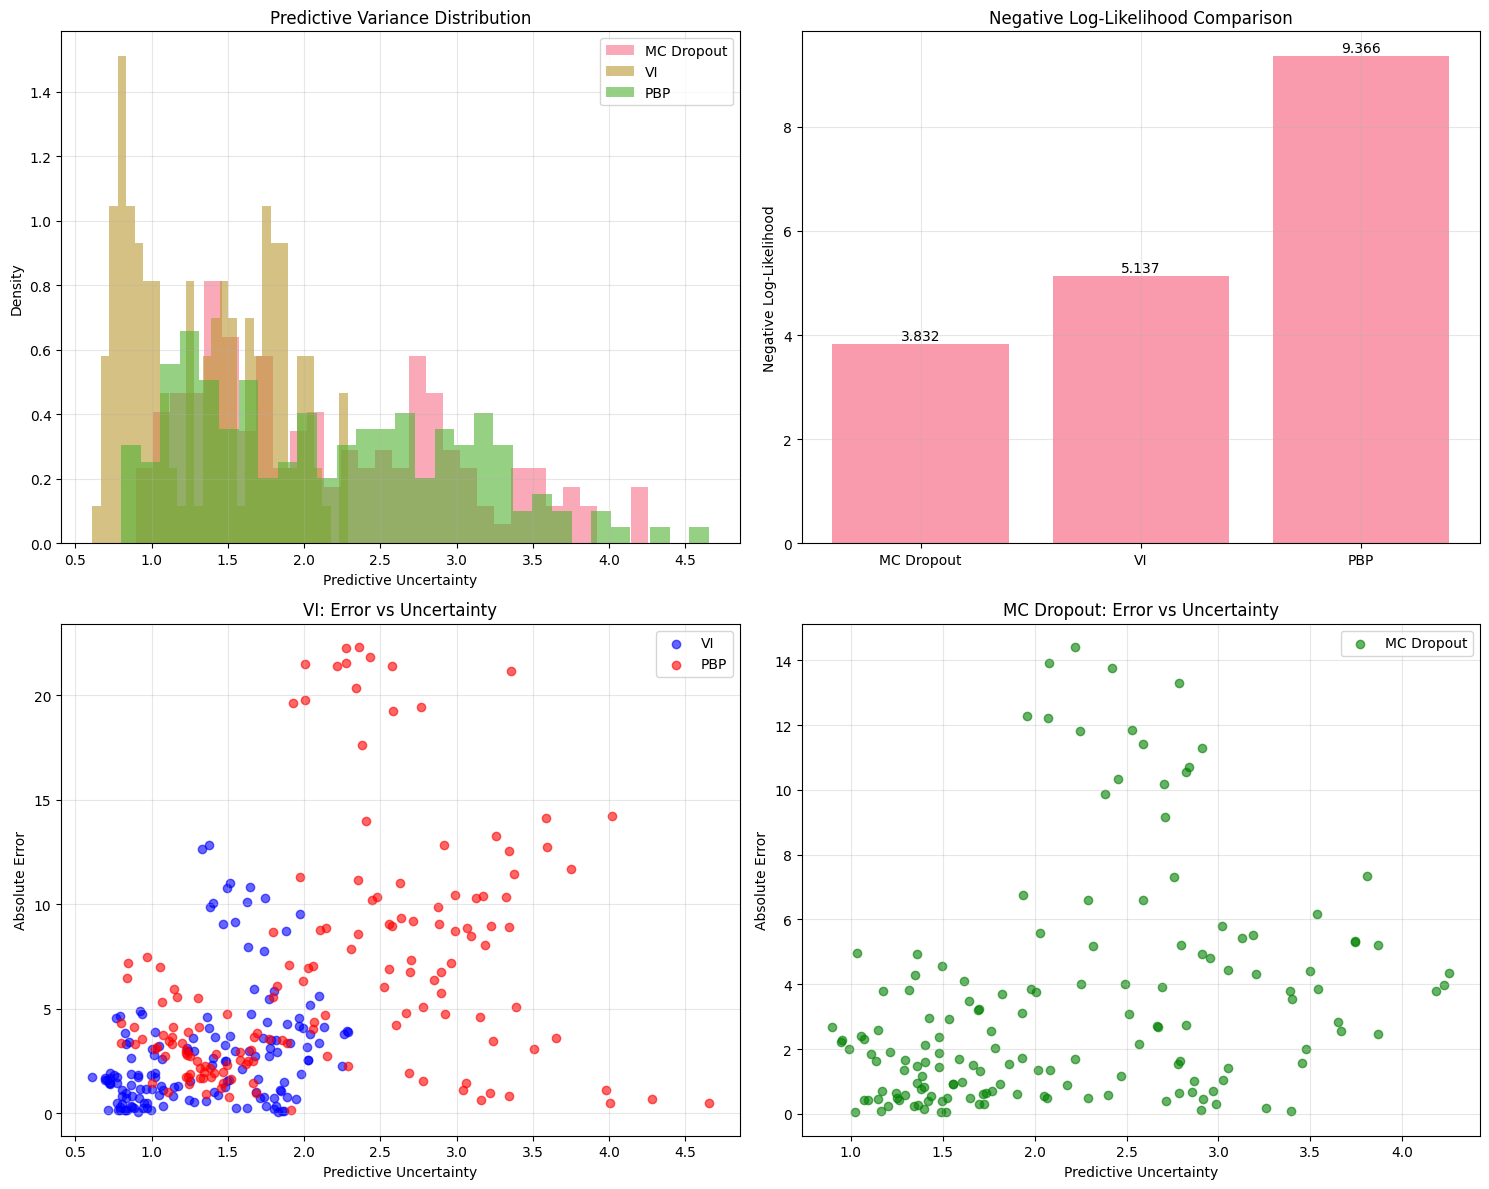

/tmp/ipykernel_49274/814572476.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=['MC Dropout', 'VI', 'PBP'])


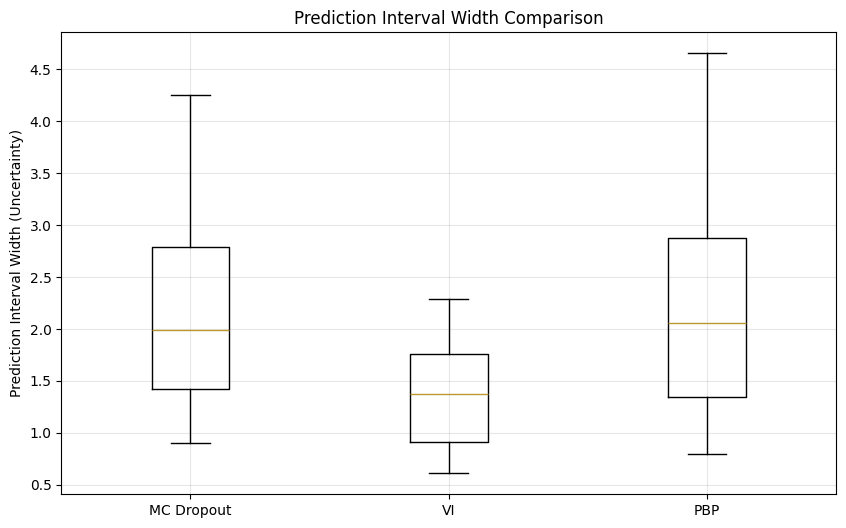

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Predictive Variance KDE Comparison
axes[0,0].hist(mc_unc, bins=30, alpha=0.6, density=True, label='MC Dropout')
axes[0,0].hist(vi_unc, bins=30, alpha=0.6, density=True, label='VI')
axes[0,0].hist(pbp_unc, bins=30, alpha=0.6, density=True, label='PBP')
axes[0,0].set_xlabel('Predictive Uncertainty')
axes[0,0].set_ylabel('Density')
axes[0,0].set_title('Predictive Variance Distribution')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Negative Log-Likelihood Bar Chart
models = ['MC Dropout', 'VI', 'PBP']
nll_values = [mc_nll, vi_nll, pbp_nll]
bars = axes[0,1].bar(models, nll_values, alpha=0.7)
axes[0,1].set_ylabel('Negative Log-Likelihood')
axes[0,1].set_title('Negative Log-Likelihood Comparison')
for bar, value in zip(bars, nll_values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                  f'{value:.3f}', ha='center', va='bottom')
axes[0,1].grid(True, alpha=0.3)

# Error vs Uncertainty Trade-Off Plot
def plot_error_uncertainty(ax, y_true, y_pred, y_unc, model_name, color):
    error = np.abs(y_true - y_pred)
    ax.scatter(y_unc, error, alpha=0.6, label=model_name, color=color)
    ax.set_xlabel('Predictive Uncertainty')
    ax.set_ylabel('Absolute Error')
    ax.set_title(f'{model_name}: Error vs Uncertainty')
    ax.legend()
    ax.grid(True, alpha=0.3)

plot_error_uncertainty(axes[1,0], y_test_np, vi_pred, vi_unc, 'VI', 'blue')
plot_error_uncertainty(axes[1,1], y_test_np, mc_pred, mc_unc, 'MC Dropout', 'green')

# Add PBP to one of the subplots
axes[1,0].scatter(pbp_unc, np.abs(y_test_np - pbp_pred), alpha=0.6, label='PBP', color='red')
axes[1,0].legend()

plt.tight_layout()
plt.show()

# Prediction Interval Width Comparison Plot
fig, ax = plt.subplots(figsize=(10, 6))
models_data = {
    'MC Dropout': mc_unc,
    'VI': vi_unc,
    'PBP': pbp_unc
}

box_data = [models_data['MC Dropout'], models_data['VI'], models_data['PBP']]
ax.boxplot(box_data, labels=['MC Dropout', 'VI', 'PBP'])
ax.set_ylabel('Prediction Interval Width (Uncertainty)')
ax.set_title('Prediction Interval Width Comparison')
ax.grid(True, alpha=0.3)
plt.show()

